# An examination of the stochastic distribution of spatial accessibility to intensive care unit (ICU) beds during the COVID-19 pandemic: a case study of the Greater Houston area of Texas

### Abstract

Sufficient and reliable health care access is necessary for people to be able to maintain good health. Hence, investigating the uncertainty embedded in the temporal changes of inputs would be beneficial for understanding their impact on spatial accessibility. However, previous studies are limited to implementing only the uncertainty of mobility, while health care resource availability is a significant concern during the coronavirus disease (COVID-19) pandemic. Our study examined the stochastic distribution of spatial accessibility under the uncertainties underlying the availability of intensive care unit (ICU) beds and ease of mobility in the Greater Houston area of Texas. Based on the randomized supply and mobility from their historical changes, we employed Monte Carlo simulation to measure ICU bed accessibility with an enhanced two-step floating catchment area (E2SFCA) method. We then conducted hierarchical clustering to classify regions of adequate (sufficient and reliable) accessibility and inadequate (insufficient and unreliable) accessibility. Lastly, we investigated the relationship between the accessibility measures and the case fatality ratio of COVID-19. As result, locations of sufficient access also had reliable accessibility; downtown and outer counties, respectively, had adequate and inadequate accessibility. We also raised the possibility that inadequate health care accessibility may cause higher COVID-19 fatality ratios.

In [11]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import pathlib
import warnings
import utils
import time
import multiprocessing as mp
import itertools
import matplotlib.patheffects as pe
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
import zipfile
import numpy as np
import jenkspy
warnings.filterwarnings('ignore')

tqdm.pandas()

# Define paths

In [2]:
# Extract files related to inputs
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
# Extract precalculated results 
# with zipfile.ZipFile('./result.zip', 'r') as zip_ref:
#     zip_ref.extractall('./result')
    
data_path = pathlib.Path('./data')
csv_path = data_path.joinpath('traffic_data', 'modified_csv')
shp_path = data_path.joinpath('traffic_data', 'shp')
result_path = pathlib.Path('./result')
PROCESSOR_NUM = 6

# 0. Problem statement
## 0.1. Uncertainty in supply (ICU beds) availability
During the second COVID-19 outbreak in Texas (from May 1 to September 30, 2020), the percentage of available ICU beds in Harris County was maximized (21.3%, 344 of 1614 operational ICU beds) on May 25, 2020, and minimized (1.4%, 24 available beds) on July 15. The availability of ICU beds is closely related to the degree of supply that hospitals provide, and there is temporal uncertainty. For instance, an increase in ICU beds availability would alleviate local competition (i.e., more resources and high supply-to-demand ratio), whereas a decrease in availability would worsen it (i.e., fewer resources; low supply-to-demand ratio). 

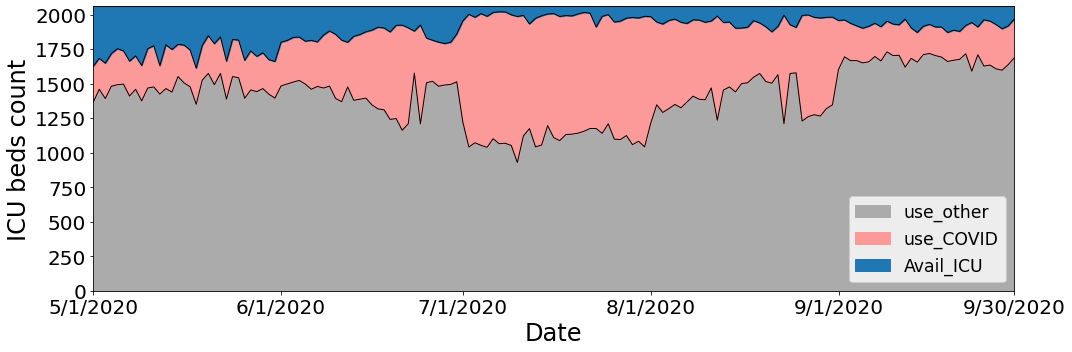

In [3]:
county_list = ['Harris', 'Fort Bend', 'Montgomery', 'Brazoria', 'Galveston', 'Liberty', 'Waller', 'Chambers', 'Austin']
staff_ICU = {'Harris': 1614, 'Fort Bend': 122, 'Montgomery': 174, 'Brazoria': 40, 
           'Galveston': 94, 'Liberty': 8, 'Waller': 0, 'Chambers': 1, 'Austin': 6}
xls_file = pd.read_csv(data_path.joinpath('hospital_availability.csv'))

ICU_usage = xls_file.groupby('Date').sum()
ICU_usage['use_other'] = ICU_usage.apply(lambda x:sum(staff_ICU.values()) - (x['Avail_ICU'] + x['COV_S_ICU'] + x['COV_C_ICU']), axis=1)
ICU_usage['use_COVID'] = ICU_usage.apply(lambda x: (x['COV_S_ICU'] + x['COV_C_ICU']), axis=1)
ICU_usage = ICU_usage.filter(items=['use_other', 'use_COVID', 'Avail_ICU'])

aval_fig = ICU_usage.plot.area(color=['#ABABAB','#fb9a99', '#1f78b4'], linewidth=1, figsize=(15, 5))
for temp_line in aval_fig.lines:
    temp_line.set_color('black')

aval_fig.set_ylim(0, sum(staff_ICU.values()))
aval_fig.set_xlim(0, 152)
aval_fig.set_ylabel('ICU beds count', fontsize=24)
aval_fig.set_xlabel('Date', fontsize=24)
plt.xticks([0, 31, 61, 92, 123, 152], ['5/1/2020', '6/1/2020', '7/1/2020', '8/1/2020', '9/1/2020', '9/30/2020'], fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right', fontsize='xx-large')
plt.tight_layout()

plt.show()

In [4]:
# Missing histrorical usage data for Liberty and Austin counties (No Hospital in Waller county)
# Therefore, we use the usage distribution of other counties to estimate theirs.
aval_ratio = pd.DataFrame(index=xls_file['Date'].unique(), columns=[f'{county}' for county in county_list])

for county in county_list:
    if county in ['Harris', 'Fort Bend', 'Montgomery', 'Brazoria', 'Galveston', 'Chambers']:  
        county_xls = xls_file.loc[xls_file['County'] == county]
        county_xls = county_xls.set_index('Date')
        county_xls['aval_ratio'] = county_xls.apply(lambda x: round((x['COV_S_ICU'] + x['COV_C_ICU'] + x['Avail_ICU']) / staff_ICU[county] * 100, 0), axis=1)
        county_xls = county_xls.filter(items=['use_other', 'use_COVID', 'aval_ratio'])
        
        aval_ratio[county] = county_xls['aval_ratio']
        
    elif county in ['Liberty', 'Austin']: # ICU availability data missing in Liberty and Austin county
        counties_xls = xls_file.groupby('Date').sum()
        counties_xls['aval_ratio'] = counties_xls.apply(lambda x: round((x['COV_S_ICU'] + x['COV_C_ICU'] + x['Avail_ICU']) / sum(staff_ICU.values()) * 100, 0), axis=1)
        aval_ratio[county] = counties_xls['aval_ratio']
        
    else: # No hospital in Waller County
        aval_ratio[county] = 0
        
aval_ratio

Harris  Fort Bend  Montgomery  Brazoria  Galveston  Liberty  \
5/1/2020     33.0       49.0        27.0      38.0       43.0     34.0   
5/2/2020     29.0       43.0        30.0      42.0       39.0     31.0   
5/3/2020     31.0       54.0        38.0      42.0       27.0     33.0   
5/4/2020     32.0       47.0        36.0       8.0       27.0     32.0   
5/5/2020     28.0       48.0        32.0      10.0       46.0     29.0   
...           ...        ...         ...       ...        ...      ...   
9/26/2020    17.0       32.0        31.0      32.0       18.0     19.0   
9/27/2020    17.0       33.0        29.0      32.0       18.0     19.0   
9/28/2020    18.0       22.0        24.0      30.0       19.0     19.0   
9/29/2020    15.0       23.0        20.0      22.0       26.0     17.0   
9/30/2020    16.0       25.0        19.0      20.0       24.0     17.0   

           Waller  Chambers  Austin  
5/1/2020        0       0.0    34.0  
5/2/2020        0       0.0    31.0  
5/3/2020        0       0.0    33.0  
5/4/2020        0       0.0    32.0  
5/5/2020        0       0.0    29.0  
...           ...       ...     ...  
9/26/2020       0       0.0    19.0  
9/27/2020       0       0.0    19.0  
9/28/2020       0       0.0    19.0  
9/29/2020       0       0.0    17.0  
9/30/2020       0       0.0    17.0  

[153 rows x 9 columns]

## 0.2. Uncertainty in mobility (travel speed)
In addition, the uncertainty of mobility would change the size and shape of the service area that a facility provides. For example, high mobility during the nighttime would expand the service area of supply, whereas low mobility during the daytime would shrink it.

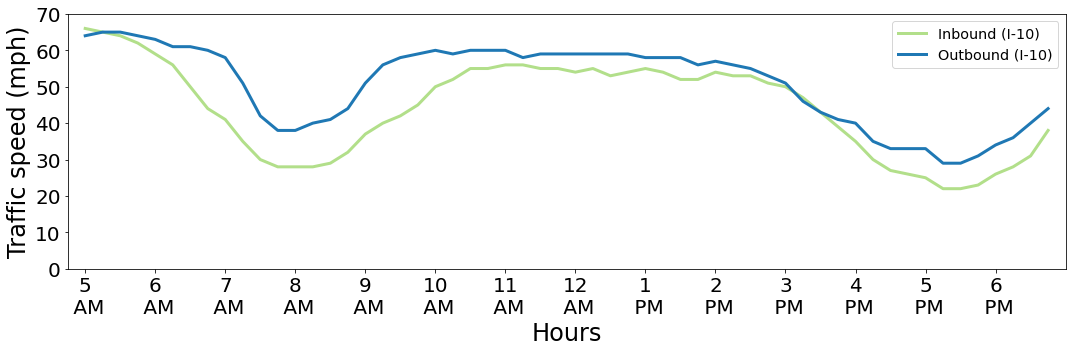

In [5]:
inbound = pd.read_csv(csv_path.joinpath('IH10K_Beltway8_Downtown.csv'))
inbound = inbound.set_index('Departure')
outbound = pd.read_csv(csv_path.joinpath('IH10K_Downtown_Beltway8.csv'))
outbound = outbound.set_index('Departure')

mobility = pd.DataFrame(index=inbound.index)
mobility['inbound'] = inbound['Average']
mobility['outbound'] = outbound['Average']
mobility

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
plt.plot(mobility.index, mobility['inbound'], label='Inbound (I-10)', color='#b2df8a', linewidth=3)
plt.plot(mobility.index, mobility['outbound'], label='Outbound (I-10)', color='#1f78b4', linewidth=3)
plt.xticks(list(range(0, 55, 4)), [f'{h}\n AM' for h in range(5, 13, 1)] + [f'{h}\n PM' for h in range(1, 7, 1)], fontsize=20)
plt.yticks(fontsize=20)
ax1.set_ylabel('Traffic speed (mph)', fontsize=24)
ax1.set_xlabel('Hours', fontsize=24)
ax1.set_xlim(-1, 56)
ax1.set_ylim(0, 70)
plt.legend(loc='upper right', fontsize='x-large')
plt.tight_layout()

## 0.3. Study Area: the Greater Houston, Texas

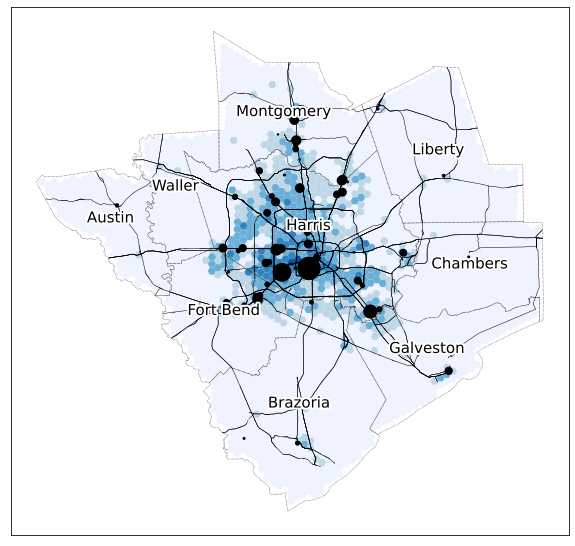

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

supply = gpd.read_file(data_path.joinpath('geocoded_hospital.shp'))
supply = supply.set_index('SupplyID')
supply = supply.loc[supply['ADULT_ICU_'] != 0]

demand = gpd.read_file(data_path.joinpath('hexagon_houston_pop.shp'))
demand = demand.set_index('GRID_ID')

boundary = gpd.read_file(data_path.joinpath('county_houston.shp'))
boundary = boundary.set_index('NAME')
road = gpd.read_file(data_path.joinpath('major_roads.shp'))

colorBrewer = ['#eff3ff', '#bdd7e7', '#6baed6', '#3182bd', '#08519c']
breaks = jenkspy.jenks_breaks(demand.Pop, nb_class=5)
for idx, cls in enumerate(breaks):
    if idx == 0:  
        continue

    temp_hxg = demand.loc[(breaks[idx-1] <= demand['Pop']) & (demand['Pop'] <= cls)]
    if temp_hxg.shape[0] > 0:
        temp_hxg.plot(ax=ax, color=colorBrewer[idx-1])

supply.plot(ax=ax, markersize=supply['ADULT_ICU_'] * 2, color='black')
boundary.apply(lambda x:ax.annotate(text=x.NAMELSAD.split('County')[0], xy=x.geometry.centroid.coords[0], ha='center', 
                                    fontsize=15, path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1)
road.plot(ax=ax, linewidth=0.5, edgecolor='k')
boundary.boundary.plot(ax=ax, linewidth=0.5, edgecolor='k', linestyle=':')
plt.show()

# 1. Analytical Framework

We used the following three steps to measure spatial accessibility to ICU beds under the temporal uncertainty of supply and mobility. 
1) Calculate the probability distribution of supply and mobility, which would be used as the randomized input variables in the Monte-Carlo simulation. <br>
2) Assess spatial accessibility to ICU beds 999 times (i.e., Monte-Carlo simulation) to investigate the impacts of the two randomized variables on the measures. The simulation provided the stochastic distribution of the measures for each location. <br>
3) Spatial clustering was implemented to group locations based on the measures and to demonstrate which locations had sufficient and reliable accessibility.<br>

<img src='./workflow.jpg' width='800'/>

## 1.1. Calculate probability distribution of supply and mobility

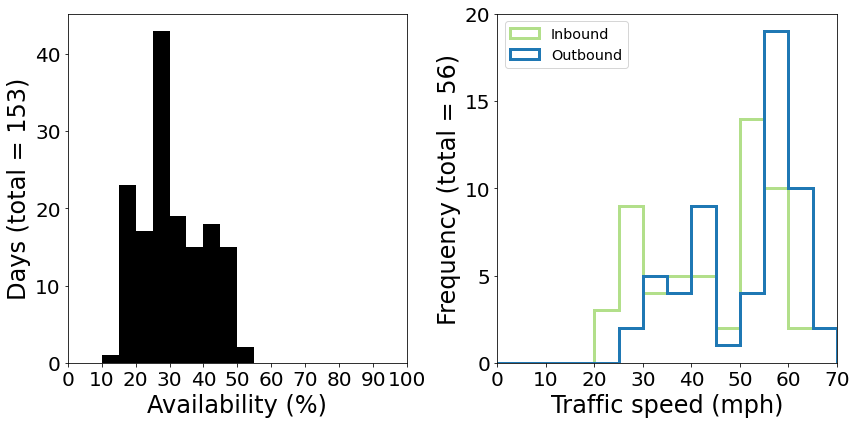

In [7]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)

aval_ratio['Harris'].hist(bins=[10, 15, 20, 25, 30, 35, 40, 45, 50, 55], ax=ax1, color='black', grid=False)
plt.xticks(list(range(0, 105, 10)), fontsize=20)
plt.yticks(fontsize=20)
ax1.set_ylabel('Days (total = 153)', fontsize=24)
ax1.set_xlabel('Availability (%)', fontsize=24)
ax1.set_xlim(0, 100)

ax2 = fig.add_subplot(1, 2, 2)
plt.hist(mobility['inbound'], bins=list(range(0, 75, 5)), label='Inbound', edgecolor='#b2df8a', linewidth=3, histtype='step')
plt.hist(mobility['outbound'], bins=list(range(0, 75, 5)), label='Outbound' , edgecolor='#1f78b4', linewidth=3, histtype='step')
plt.legend(loc='upper left', fontsize='x-large')
ax2.set_ylabel('Frequency (total = 56)', fontsize=24)
ax2.set_xlabel('Traffic speed (mph)', fontsize=24)
ax2.set_xlim(0, 70)
plt.xticks(fontsize=20)
plt.yticks([0, 5, 10, 15, 20],fontsize=20)

plt.tight_layout()

In [8]:
# Calculate the percentage of how many percentage of ICU beds are available
probs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

supply_prob = pd.DataFrame(index=county_list, columns=probs)
for county in county_list:
    for idx, val in enumerate(probs):
        if idx == len(probs) - 1:
            break
            
        supply_prob.loc[county, probs[idx+1]] = aval_ratio.loc[(aval_ratio[county] >= val*100) & (aval_ratio[county] < probs[idx +1]*100)].shape[0]
    
supply_prob = supply_prob / 153
supply_prob = supply_prob.drop(columns=[0.0])

for county in ['Liberty', 'Austin']:
    for col in [0.2, 0.4, 0.6, 0.8, 1.0]:
        supply_prob.loc[county, col] = supply_prob.loc[['Harris', 'Fort Bend', 'Montgomery', 
                                                        'Brazoria', 'Galveston', 'Chambers'], col].mean(axis=0)

for col in supply_prob.columns:
    supply_prob[col] = supply_prob[col].astype(float)

supply_prob = supply_prob.round(decimals=3)  
for idx in supply_prob.index:
    sum_prob = round(supply_prob.loc[idx].sum(), 3)
    if sum_prob < 1:
        supply_prob.loc[idx, 1.0] += 1 - sum_prob
        
    elif sum_prob > 1:
        supply_prob.loc[idx, 0.2] -= sum_prob - 1

supply_prob

0.2    0.4    0.6    0.8    1.0
Harris      0.157  0.614  0.229  0.000  0.000
Fort Bend   0.052  0.301  0.490  0.150  0.007
Montgomery  0.144  0.673  0.176  0.007  0.000
Brazoria    0.098  0.477  0.340  0.085  0.000
Galveston   0.046  0.412  0.359  0.170  0.013
Liberty     0.246  0.413  0.266  0.069  0.006
Waller      1.000  0.000  0.000  0.000  0.000
Chambers    0.980  0.000  0.000  0.000  0.020
Austin      0.246  0.413  0.266  0.069  0.006

## 1.2. Monte-Carlo simulation of spatial accessibility measurements

In [9]:
# Import mobility-related files
file_names = pd.read_csv(data_path.joinpath('traffic_data', 'file_names.txt'), header=None)
original_nodes = gpd.read_file(data_path.joinpath('osm_network_greater_houston', 'nodes.shp'))
merged_edge = utils.road_network_with_uncertainty(file_names, data_path)
merged_edge = merged_edge.set_crs(epsg=4326)
G = utils.construct_network(merged_edge, original_nodes)
G = utils.remove_uncenessary_nodes(G)

# Find nearest node of OSM from supply and demand locations
supply = utils.find_nearest_osm(G, supply)
demand = utils.find_nearest_osm(G, demand)

{'razed', 'toll_gantry', "['road', 'residential']", 'disused', 'road'}


100%|████████████████████████████████| 262552/262552 [00:14<00:00, 18499.58it/s]


Removed 644 nodes (0.0025%) from the OSMNX network
Number of nodes: 261908
Number of edges: 637266


100%|███████████████████████████████████████| 2857/2857 [55:09<00:00,  1.16s/it]


In [13]:
'''
This cell demonstrates only six-iteration of accessibility measurements out of the original 999 iterations 
to demonstrate how the Monte-Carlo simulation works. If you want to increase the iteration count to 999, 
change `range(PROCESSOR_NUM)` to `range(999)`. This change will introduce a severe computational intensity 
and would take a couple of months to finish the measurements depends on the specification of computational infrastructure.
'''

# # Set threshold travel time and corresponding spatial impedance
# minutes = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60]
# weights = {0: 1, 5: 0.9459, 10: 0.7544, 15: 0.5511, 20: 0.3993, 25: 0.2957, 30: 0.2253, 
#            35: 0.1765, 40: 0.1417, 45: 0.1161, 60: 0.0832}


# start = int(time.time())
# pool = mp.Pool(processes = PROCESSOR_NUM)
# access_result = pool.map(utils.measure_accessibility_unpacker,
#                          zip(range(PROCESSOR_NUM),
#                              itertools.repeat(supply),
#                              itertools.repeat(demand),
#                              itertools.repeat(supply_prob),
#                              itertools.repeat(file_names),
#                              itertools.repeat(original_nodes),
#                              itertools.repeat(minutes),
#                              itertools.repeat(weights),
#                              itertools.repeat(data_path),
#                              itertools.repeat(result_path)
#                             )
#                         )
# end = int(time.time())
# pool.close()
# print("***run time(min) : ", (end-start)/60)

'\nThis cell demonstrates only six-iteration of accessibility measurements out of the original 999 iterations \nto demonstrate how the Monte-Carlo simulation works. If you want to increase the iteration count to 999, \nchange `range(PROCESSOR_NUM)` to `range(999)`. This change will introduce a severe computational intensity \nand would take a couple of months to finish the measurements.\n'

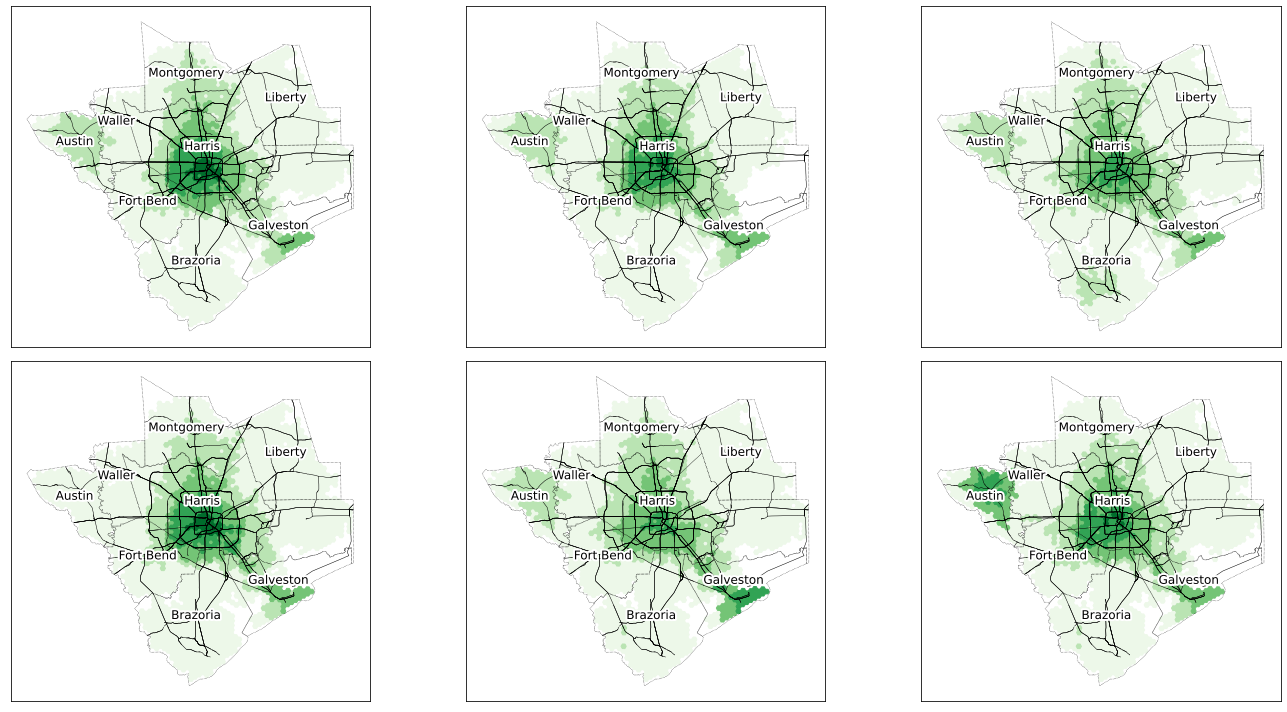

In [14]:
plt_cls = [0, 5, 10, 15, 20, 25]
colors = ['#edf8e9', '#bae4b3', '#74c476', '#31a354', '#006d2c']

fig = plt.figure(figsize=(20, 10))
for i in range(PROCESSOR_NUM):
    ax = fig.add_subplot(2, 3, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    temp_result = gpd.read_file(result_path.joinpath (f'iter_{i}', 'demand.geojson'))
    
    for idx, cls in enumerate(plt_cls):
        if idx == 0: continue
        temp_cls = temp_result.loc[(plt_cls[idx-1] < temp_result[f'step2']) & (temp_result[f'step2'] <= cls)]
        if temp_cls.shape[0] > 0:
            temp_cls.plot(ax=ax, color=colors[idx-1], edgecolor=colors[idx-1])
            
    boundary.apply(lambda x:ax.annotate(text=x.NAMELSAD.split('C')[0], xy=x.geometry.centroid.coords[0], ha='center', 
                                    fontsize=12, path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1)
    
    road.plot(ax=ax, linewidth=0.5, edgecolor='k')
    boundary.boundary.plot(ax=ax, linewidth=0.5, edgecolor='k', linestyle=':')
            
plt.tight_layout()
plt.show()

## 1.3. Spatial clustering

In [15]:
# Import the precalculated result for the demonstration purpose
measures = gpd.read_file(result_path.joinpath(r'precalculated_measures.shp'))
measures = measures.loc[measures['Note'] != 'water']
measures = measures.fillna(0)
measures = measures.set_index('GRID_ID')
measures.head()

OBJECTID_1     Note    Shape_Leng    Shape_Area  Pop       n_1  \
GRID_ID                                                                   
AR-66             2  no_node  10590.960394  8.095060e+06  0.0  0.000000   
AP-65             6        0  10590.960740  8.095061e+06  0.0  0.490869   
AR-65             7  no_node  10590.960740  8.095061e+06  0.0  0.637447   
AS-65             8  no_node  10590.960340  8.095060e+06  0.0  0.637447   
AT-65             9  no_node  10590.960740  8.095061e+06  0.0  0.637447   

              n_2       n_3       n_4       n_5  ...     n_991     n_992  \
GRID_ID                                          ...                       
AR-66    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
AP-65    0.170959  0.392004  0.531646  0.474282  ...  0.544134  0.364342   
AR-65    0.170959  0.343231  0.531646  0.567732  ...  0.585538  0.364342   
AS-65    0.170959  0.343231  0.531646  0.567732  ...  0.585538  0.364342   
AT-65    0.170959  0.343231  0.531646  0.567732  ...  0.585538  0.364342   

            n_993     n_994     n_995     n_996     n_997     n_998     n_999  \
GRID_ID                                                                         
AR-66    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
AP-65    0.514774  0.340968  0.583251  0.287596  0.517695  0.454163  0.372794   
AR-65    0.611867  0.393666  0.493596  0.287596  0.464520  0.397227  0.358038   
AS-65    0.611867  0.393666  0.493596  0.287596  0.464520  0.397227  0.358038   
AT-65    0.611867  0.393666  0.493596  0.287596  0.464520  0.397227  0.358038   

                                                  geometry  
GRID_ID                                                     
AR-66    POLYGON ((-95.46480 28.83302, -95.47431 28.819...  
AP-65    POLYGON ((-95.51810 28.86203, -95.52761 28.848...  
AR-65    POLYGON ((-95.46385 28.86060, -95.47336 28.847...  
AS-65    POLYGON ((-95.43720 28.84609, -95.44672 28.832...  
AT-65    POLYGON ((-95.40959 28.85914, -95.41912 28.845...  

[5 rows x 1005 columns]

In [16]:
# Calculate descriptive statistics of the monte-carlo simulation result
measures['p05'] = measures[[f'n_{i}' for i in range(1, 1000)]].quantile(0.95, axis=1)
measures['p25'] = measures[[f'n_{i}' for i in range(1, 1000)]].quantile(0.75, axis=1)
measures['p50'] = measures[[f'n_{i}' for i in range(1, 1000)]].quantile(0.50, axis=1)
measures['p75'] = measures[[f'n_{i}' for i in range(1, 1000)]].quantile(0.25, axis=1)
measures['p95'] = measures[[f'n_{i}' for i in range(1, 1000)]].quantile(0.05, axis=1)

measures['mean'] = measures[[f'n_{i}' for i in range(1, 1000)]].mean(axis=1)
measures['std'] = measures[[f'n_{i}' for i in range(1, 1000)]].std(axis=1)
measures['cv'] = measures['std'] / measures['mean']
measures = measures.fillna(0)

Z-19 3.5479404339471095 0.22708169235648717
AX-27 11.492793800367348 0.966447643595205
AT-33 21.51333208226178 1.678546812397212
BK-46 7.428480822881289 0.8623739246139915


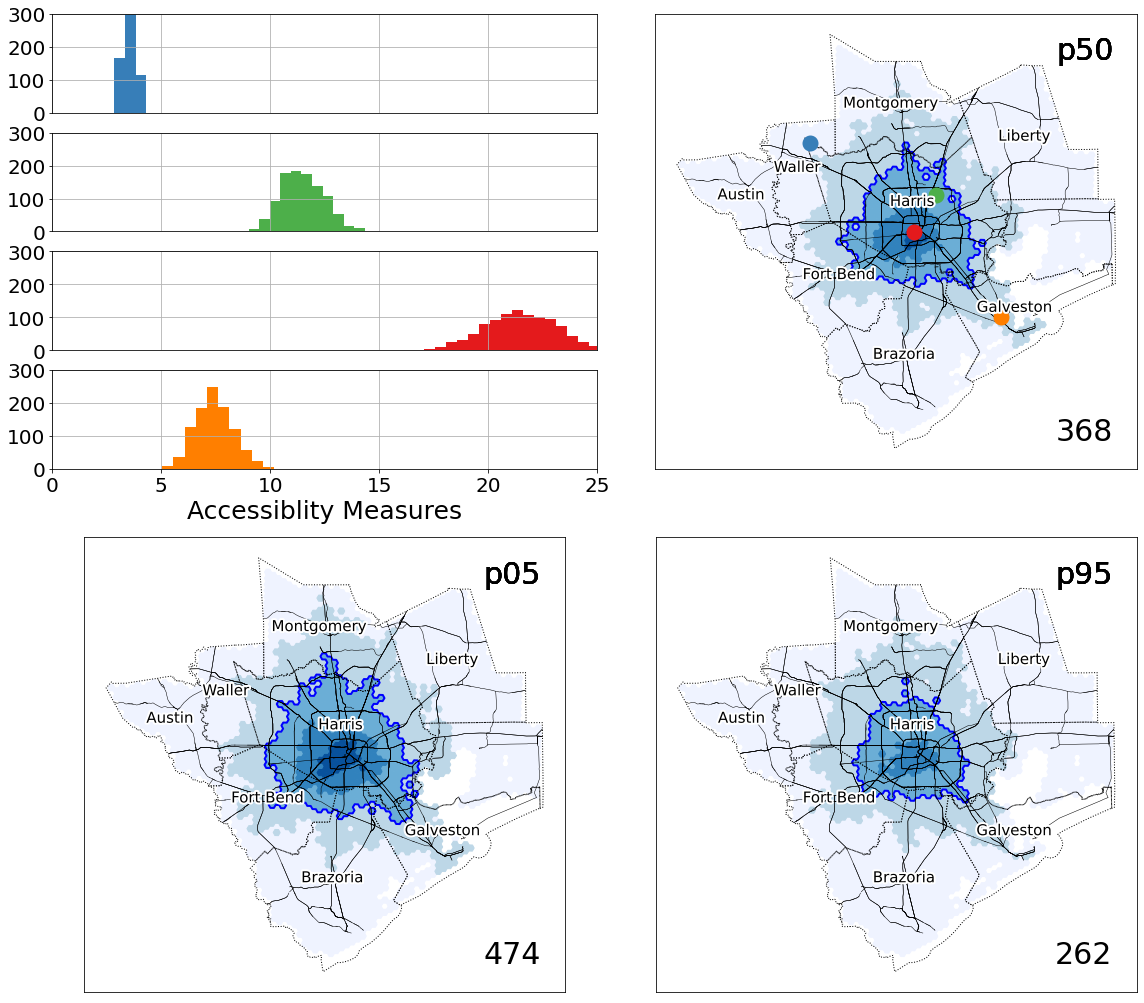

In [17]:
colors = ['#eff3ff', '#bdd7e7', '#6baed6', '#3182bd', '#08519c']
plt_cls = [0, 5, 10, 15, 20, 25]
good_acc_value = 10
hxg_plot = ['Z-19','AX-27', 'AT-33', 'BK-46']
hxg_colors = ['#377eb8', '#4daf4a', '#e41a1c', '#ff7f00']

fig = plt.figure(figsize=(20, 18))
outer = gridspec.GridSpec(2, 2, wspace=0.05, hspace=0.15)
for idx, ratio in enumerate(['p50', 'p05', 'p95']):
    ax = plt.Subplot(fig, outer[idx+1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for idx, cls in enumerate(plt_cls):
        if idx == 0: continue
        temp_hxg = measures.loc[(plt_cls[idx-1] < measures[f'{ratio}']) & (measures[f'{ratio}'] <= cls)]
        if temp_hxg.shape[0] > 0:
            temp_hxg.plot(ax=ax, color=colors[idx-1], edgecolor=colors[idx-1])
        ax.text(0.95, 0.95, str(ratio), fontsize=30, ha='right', va='top', transform=ax.transAxes)
    
    good_acc = measures.loc[measures[f'{ratio}'] >= good_acc_value]
    good_acc['dummy'] = 'dummy'
    good_acc.dissolve(by='dummy').boundary.plot(ax=ax, color=None, edgecolor='blue', linewidth=2)
    ax.text(0.95, 0.05, str(good_acc.shape[0]), fontsize=30, ha='right', va='bottom', transform=ax.transAxes)
    
    # supplementary poi
    boundary.apply(lambda x:ax.annotate(text=x.NAMELSAD.split('C')[0], xy=x.geometry.centroid.coords[0], ha='center', 
                                        fontsize=15, path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1)
    road.plot(ax=ax, linewidth=0.5, edgecolor='k')
    boundary.boundary.plot(ax=ax, linewidth=1, edgecolor='k', linestyle=':')
    fig.add_subplot(ax)
    
    if ratio == 'p50':
        for idx_2, hxg in enumerate(hxg_plot):
            measures.loc[measures.index == hxg].plot(color=hxg_colors[idx_2], ax=ax)
            measures.loc[measures.index == hxg].centroid.plot(color=hxg_colors[idx_2], ax=ax, linewidth=10, zorder=2)
            print(hxg, measures.loc[measures.index == hxg]['mean'].values[0], measures.loc[measures.index == hxg]['std'].values[0])
                
        inner = gridspec.GridSpecFromSubplotSpec(4, 1,
                subplot_spec=outer[0], wspace=0.1, hspace=0.2)
        # Histogram
        for idx_1, hxg in enumerate(hxg_plot):
            ax1 = plt.Subplot(fig, inner[idx_1])
            temp_df = measures.loc[hxg, [f'n_{num}' for num in range(1, 1000)]]
            bins = round((temp_df.max() - temp_df.min()) / 0.5)
            temp_df.hist(ax=ax1, color=hxg_colors[idx_1], bins=bins)

            ax1.set_xlim(0, 25)
            ax1.set_ylim(0, 300)
            ax1.set_yticks([0, 100, 200, 300])
            ax1.tick_params(axis='both', labelsize=20)
            ax1.grid(True)
            
            if idx_1 != 3:
                plt.setp(ax1.get_xticklabels(), visible=False)
                ax1.tick_params(axis='x', which='both', length=0)
            else:
                ax1.set_xticks([0, 5, 10, 15, 20, 25])
                ax1.set_xlabel('Accessiblity Measures', fontsize=25)
            fig.add_subplot(ax1)
    else:
        pass
    
plt.tight_layout()
plt.show()

Number of Hexagons | color hex code | Population | Min Acc, Mean Acc, Max Acc | Mean CV
369 | #80cdc1 | 3276713.0 | 9.008 11.466 15.063 | 0.07
988 | #dfc27d | 479899.0 | 1.904 3.706 5.742 | 0.092
485 | #c7eae5 | 1376696.0 | 5.654 7.319 9.284 | 0.076
762 | #a6611a | 88793.0 | 0.0 0.907 2.196 | 0.532
85 | #01665e | 1822788.0 | 15.13 17.435 21.513 | 0.076


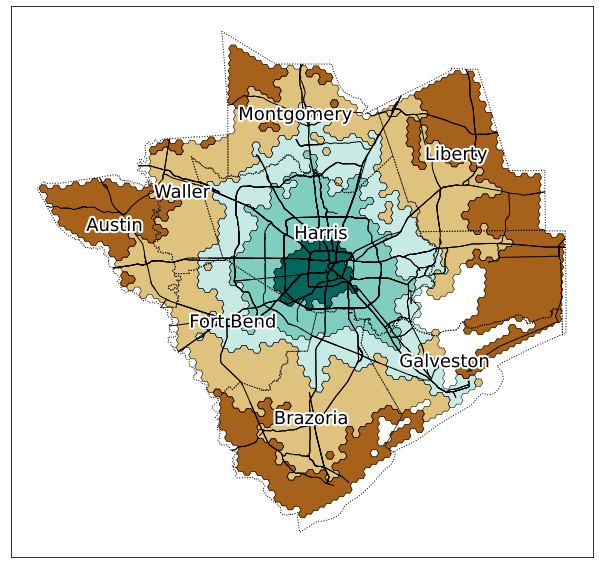

In [18]:
color_list = ['#80cdc1', '#dfc27d', '#c7eae5', '#a6611a', '#01665e']

m_acc = measures[[f'n_{i}' for i in range(1, 1000)]]  # Only columns of values
m_acc = m_acc.fillna(0)

clustering = AgglomerativeClustering(n_clusters = 5, linkage='ward').fit(m_acc)
measures['cluster'] = clustering.labels_
print('Number of Hexagons', '|',  'color hex code','|',  'Population', '|', 'Min Acc, Mean Acc, Max Acc', '|', 'Mean CV')
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
for i in range(5):    
    tt = measures.loc[measures['cluster'] == i]
    print(tt.shape[0], '|', color_list[i],'|',  tt['Pop'].sum(), '|', round(tt['mean'].min(),3), round(tt['mean'].mean(),3), round(tt['mean'].max(),3), '|',round(tt['cv'].mean(), 3))
    tt.plot(ax=ax, color=color_list[i], edgecolor=color_list[i])
    tt.dissolve('cluster').boundary.plot(color='black', ax=ax, linewidth=0.5)
        
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# supplementary poi
boundary.apply(lambda x:ax.annotate(text=x.NAMELSAD.split('C')[0], xy=x.geometry.centroid.coords[0], ha='center', 
                                    fontsize=18, path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1)
road.plot(ax=ax, linewidth=1, edgecolor='k')
boundary.boundary.plot(ax=ax, linewidth=1, edgecolor='k', linestyle=':')
plt.tight_layout()
plt.show()

2 0.6193 [0 0 0 ... 0 0 0]
3 0.5187 [0 0 0 ... 0 0 0]
4 0.5146 [0 0 0 ... 0 0 0]
5 0.5286 [0 0 0 ... 0 0 0]
6 0.5228 [0 0 0 ... 0 0 0]
7 0.4791 [0 0 0 ... 0 0 0]
8 0.469 [0 0 0 ... 0 0 0]
9 0.436 [0 0 0 ... 1 1 0]
10 0.4351 [0 0 0 ... 1 1 0]


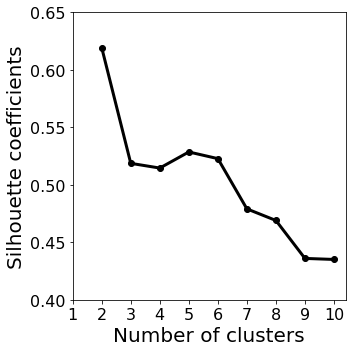

In [19]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)

list_silhouette = []
for i in range(2, 11):
    cluster_labels = hierarchy.cut_tree(hierarchy.ward(m_acc), n_clusters=i).T[0]
    list_silhouette.append(round(silhouette_score(m_acc, cluster_labels), 4))
    print(i, round(silhouette_score(m_acc, cluster_labels), 4), cluster_labels)
    
plt.plot(range(2, 11), list_silhouette, color='black', linewidth='3', marker='o', linestyle='solid')
plt.xticks(list(range(0, 11, 1)), fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Number of clusters', fontsize=20)
ax.set_ylabel('Silhouette coefficients', fontsize=20)
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0.4, ymax= 0.65)
plt.tight_layout()

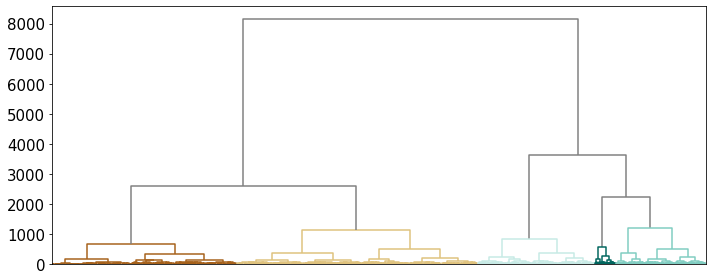

In [20]:
temp_measures = measures.reset_index()

Z = hierarchy.linkage(m_acc.to_numpy(), 'ward')
dn = hierarchy.dendrogram(Z, labels=measures.index.to_list(), no_plot=True)

D_leaf_colors = {}
for leaf_idx in dn['leaves']:
    leaf_cluster = temp_measures.loc[leaf_idx, 'cluster']
    D_leaf_colors[leaf_idx] = color_list[leaf_cluster]

dflt_col = "#808080" 
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(Z) else D_leaf_colors[x] for x in i12)
    link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col
    
plt.figure(figsize=(10,4))
D = hierarchy.dendrogram(Z=Z, link_color_func=lambda x: link_cols[x], no_labels=True)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

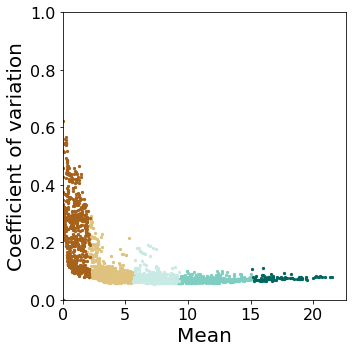

In [21]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)

for i in range(5):
    tt = measures.loc[measures['cluster'] == i]
    plt.scatter(tt['mean'].values, tt['cv'], s=5, color=color_list[i])

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0, ymax=1)
ax.set_xlabel('Mean', fontsize=20)
ax.set_ylabel('Coefficient of variation', fontsize=20)
plt.tight_layout()
# plt.savefig('mean_cv_1.jpg')
plt.show()

# 2. Relationship between accessibility and case-fatality ratio
We observed a trend where the case fatality ratio of COVID-19 can be attributed to unsatisfactory accessibility even though it may not be statistically significant because of the limited number of samples (n = 9 counties). Three of nine counties showed a higher case fatality rate than the average in the study area. While 18‰ (18 fatalities per 1,000 people) of the case fatality rate was observed as of September 30, 2020, Liberty, Austin, and Harris counties had case fatality rates of 23‰, 20‰, and 19‰, respectively. Liberty and Austin counties had insufficient (mean accessibility: 2.09 and 1.64) and unreliable (mean CV of accessibility: 0.13 and 0.27) accessibility. Therefore, their high rates can be related to the attributes of their accessibility. However, Harris County had a robust accessibility (mean accessibility: 10.39, and mean CV: 0.07). Its casualty could be caused by the intensive transmission of the virus within a short period, which was often reported in a high-density city such as New York.

In [22]:
# Calculate case-fatality ratio of each county until September 30, 2020.
case = pd.read_excel(data_path.joinpath('covid_case.xlsx'), header=2, index_col='County Name')
case_texas = case.loc['Total','Cases 09-30-2020']
case_study_area = case.loc[['Harris', 'Fort Bend', 'Montgomery', 'Brazoria', 'Galveston', 'Liberty', 'Waller', 'Chambers', 'Austin'], 'Cases 09-30-2020']
case_study_area.index = case_study_area.index.str.lower()

death = pd.read_excel(data_path.joinpath('covid_fatality.xlsx'), header=2, index_col='County Name')
death_texas = death.loc['Total', 'Fatalities 09-30-2020']
death_study_area = death.loc[['Harris'.upper(), 'Fort Bend'.upper(), 'Montgomery'.upper(), 'Brazoria'.upper(), 'Galveston'.upper(), 'Liberty'.upper(), 'Waller'.upper(), 'Chambers'.upper(), 'Austin'.upper()], 'Fatalities 09-30-2020']
death_study_area.index = death_study_area.index.str.lower()

death_ratio = pd.DataFrame({'case': case_study_area, 'death': death_study_area})
death_ratio['ratio'] = death_ratio['death'] / death_ratio['case'] * 1000
death_ratio_texas = death_texas / case_texas
death_ratio

case   death      ratio
County Name                             
harris       142315.0  2751.0  19.330359
fort bend     16387.0   299.0  18.246171
montgomery    10773.0   169.0  15.687367
brazoria      11440.0   176.0  15.384615
galveston     11670.0   165.0  14.138817
liberty        2254.0    54.0  23.957409
waller          858.0    15.0  17.482517
chambers       1342.0     8.0   5.961252
austin          497.0    10.0  20.120724

In [23]:
# Calculate the mean and coefficient of variance of accessibility to ICU beds per each county
measures.loc[measures['cv'] > 1, 'cv'] = 1

death_ratio['acc_mean'] = 0.0
death_ratio['acc_cv'] = 0.0

for idx, row in boundary.iterrows():
    temp_mean = measures.loc[measures.geometry.intersects(row.geometry),  'mean'].mean()
    temp_cv = measures.loc[measures.geometry.intersects(row.geometry),  'cv'].mean()
    
    county_name = idx.lower()
    
    death_ratio.at[county_name, 'acc_mean'] = temp_mean
    death_ratio.at[county_name, 'acc_cv'] = temp_cv
    
death_ratio

case   death      ratio   acc_mean    acc_cv
County Name                                                  
harris       142315.0  2751.0  19.330359  10.387297  0.068745
fort bend     16387.0   299.0  18.246171   6.687384  0.079106
montgomery    10773.0   169.0  15.687367   4.908209  0.084132
brazoria      11440.0   176.0  15.384615   3.448457  0.163034
galveston     11670.0   165.0  14.138817   4.699122  0.195427
liberty        2254.0    54.0  23.957409   2.086191  0.131980
waller          858.0    15.0  17.482517   3.557338  0.095077
chambers       1342.0     8.0   5.961252   2.076161  0.223118
austin          497.0    10.0  20.120724   1.637738  0.271332

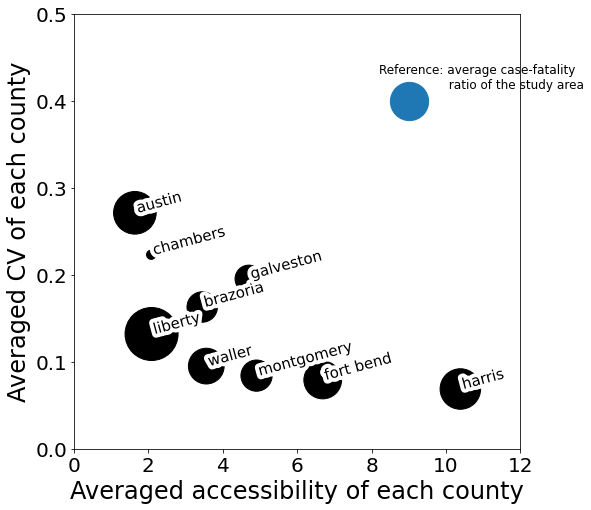

In [24]:
study_area_ratio = death_ratio.death.sum()/death_ratio.case.sum()*1000

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.scatter(death_ratio['acc_mean'], death_ratio.acc_cv, death_ratio.ratio**2.5, color='black')
ax.scatter(9, 0.4, study_area_ratio**2.5)  # total case-fatality ratio of the study area
ax.text(x=8.2, y=0.415,  s='Reference: average case-fatality \n                  ratio of the study area', fontsize=12)

ax.set_xlim(xmin=0, xmax=12)
ax.set_ylim(ymin=0, ymax=0.5)
ax.set_xlabel('Averaged accessibility of each county', fontsize=24)
ax.set_ylabel('Averaged CV of each county', fontsize=24)

for idx, row in death_ratio.iterrows():
    ax.text(x=row['acc_mean'], y=row['acc_cv'], s=idx, rotation=15, fontsize=15, path_effects=[pe.withStroke(linewidth=8, foreground="white")])


0.4377207350408868
0.4543094255661144
0.4721107739285367


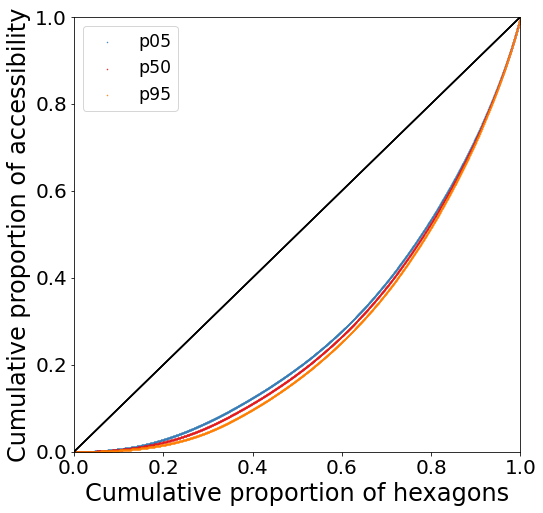

In [25]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area


fig, ax = plt.subplots(figsize=[8,8])

plot_colors = ['#377eb8', '#e41a1c', '#ff7f00']
for idx, ratio in enumerate(['p05', 'p50', 'p95']):
    X = measures[f'{ratio}'].to_numpy(copy=True)
    X.sort()
    
    print(gini(X))
    
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    X_lorenz[0], X_lorenz[-1]

    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='.', s=1, label=ratio, color=plot_colors[idx])
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlim(xmin=0, xmax=1)
ax.set_ylim(ymin=0, ymax=1)
ax.set_ylabel('Cumulative proportion of accessibility', fontsize=24)
ax.set_xlabel('Cumulative proportion of hexagons', fontsize=24)
plt.legend(fontsize='xx-large')